In [1]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import metrics
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
%matplotlib inline  
from functions import truncate_sequence,one_hot_split,preprocess_data,create_model,deeper_AE,deeper_AE4,binary_preprocess_data,Encoding

In [2]:


list_of_input_paths=["data/sarscov2.fna",
                     "data/alphacov.fna",
"data/deltacov.fna","data/mers.fna","data/JAMMSM0917_nanopore2500.fa"]




output_path = "data/data.txt"



colour=['royalblue','goldenrod','darkgreen','firebrick','slategrey']
labels=['nanopore','sarscov2','alphacov','deltacov','mers']


color_dict = dict(zip(labels,colour))
y2label=dict(zip(list(range(len(labels))),labels))


<AxesSubplot:>

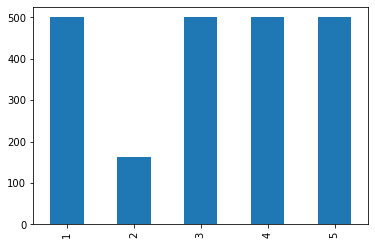

In [3]:

lr=1e-6
N=500

n_class=5
n_epoch=100
batch_size=32

atomic_size=20000000000000000000


preprocess_data(list_of_input_paths,output_path,atomic_size,N,counting_method='truncated_sequence')
df = pd.read_table('data/data.txt')
df['class'].value_counts().sort_index().plot.bar()
#X_train,y_train,X_test,y_test=one_hot_split(df,atomic_size,test_size=0.25)







In [4]:
genome = pd.read_table('data/data.txt')
print(genome.head())
print(len(genome))

                                            sequence  class
0  ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...      1
1  CAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTT...      1
2  ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...      1
3  ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...      1
4  TTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGAT...      1
2164


In [5]:
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(genome['sequence'], genome['class'], test_size = 0.20, random_state=0)

#fix random state to generate reproducible test training partition

In [6]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1


# optimise NB wrt k and n

In [57]:
Kmer=[2,3,4,5]
Ngram_size=[3,5,10]
Y_NB_Kmer_Ngram=[[] for i in range(len(Kmer))]

k=0
for kmer in Kmer:
    for ngram_size in Ngram_size:
        genome = pd.read_table('data/data.txt')
        genome['words'] = genome.apply(lambda x: getKmers(x['sequence'],size=kmer), axis=1)
        genome = genome.drop('sequence', axis=1)
        genome_texts = list(genome['words'])
        for item in range(len(genome_texts)):
            genome_texts[item] = ' '.join(genome_texts[item])
        y = genome.iloc[:, 0].values     
        cv = CountVectorizer(ngram_range=(ngram_size,ngram_size))
        X = cv.fit_transform(genome_texts)
        cv_dataframe=pd.DataFrame(X.toarray(),columns=cv.get_feature_names())
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)
        cv_X_test=pd.DataFrame(X_test.toarray(),columns=cv.get_feature_names())

        NB = MultinomialNB(alpha=0.1)
        NB.fit(X_train, y_train)
        y_NB= NB.predict(X_test)
        Y_NB_Kmer_Ngram[k].append(y_NB)
    k+=1
        
    
    
for k in range(len(Kmer)):
    for n in range(len(Ngram_size)):
        y_NB=Y_NB_Kmer_Ngram[k][n]
        
        accuracy, precision, recall, f1 = get_metrics(y_test, y_NB)
        print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))          
        print("Confusion matrix\n")
        print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_NB, name='Predicted')))    

accuracy = 0.935 
precision = 0.936 
recall = 0.935 
f1 = 0.935
Confusion matrix

Predicted    1    2
Actual             
1          182   18
2            8  192
accuracy = 0.993 
precision = 0.993 
recall = 0.993 
f1 = 0.992
Confusion matrix

Predicted    1    2
Actual             
1          200    0
2            3  197
accuracy = 1.000 
precision = 1.000 
recall = 1.000 
f1 = 1.000
Confusion matrix

Predicted    1    2
Actual             
1          200    0
2            0  200
accuracy = 0.980 
precision = 0.981 
recall = 0.980 
f1 = 0.980
Confusion matrix

Predicted    1    2
Actual             
1          200    0
2            8  192
accuracy = 1.000 
precision = 1.000 
recall = 1.000 
f1 = 1.000
Confusion matrix

Predicted    1    2
Actual             
1          200    0
2            0  200
accuracy = 1.000 
precision = 1.000 
recall = 1.000 
f1 = 1.000
Confusion matrix

Predicted    1    2
Actual             
1          200    0
2            0  200
accuracy = 0.993 
precision 

In [58]:
Accuracy_Kmer_Ngram=[[] for i in range(len(Kmer))]   
for k in range(len(Kmer)):
    for n in range(len(Ngram_size)):
        y_NB=Y_NB_Kmer_Ngram[k][n] 
        accuracy, precision, recall, f1 = get_metrics(y_test, y_NB)
        Accuracy_Kmer_Ngram[k].append(accuracy)   

In [59]:
Accuracy_Kmer_Ngram

[[0.935, 0.9925, 1.0], [0.98, 1.0, 1.0], [0.9925, 1.0, 1.0], [1.0, 1.0, 1.0]]

# EM and NB

In [11]:
Kmer=[3,4]
ngram_size=2
Y_EM_Kmer=[]
Y_NB_Kmer=[]
for kmer in Kmer:
    genome = pd.read_table('data/data.txt')
    genome['words'] = genome.apply(lambda x: getKmers(x['sequence'],size=kmer), axis=1)
    genome = genome.drop('sequence', axis=1)
    genome_texts = list(genome['words'])
    for item in range(len(genome_texts)):
        genome_texts[item] = ' '.join(genome_texts[item])
    y = genome.iloc[:, 0].values     
    
    cv = CountVectorizer(ngram_range=(ngram_size,ngram_size))
    X = cv.fit_transform(genome_texts)

    cv_dataframe=pd.DataFrame(X.toarray(),columns=cv.get_feature_names())

    X_dense=X.toarray()
    gmm = GaussianMixture(n_components=5).fit(X_dense)
    y_EM = gmm.predict(X_dense)
    Y_EM_Kmer.append(y_EM)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)
    cv_X_test=pd.DataFrame(X_test.toarray(),columns=cv.get_feature_names())


    NB = MultinomialNB(alpha=0.1)
    NB.fit(X_train, y_train)
    y_NB= NB.predict(X_test)
    Y_NB_Kmer.append(y_NB)


for y_NB in Y_NB_Kmer:
    accuracy, precision, recall, f1 = get_metrics(y_test, y_NB)
    print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))          
    print("Confusion matrix\n")
    print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_NB, name='Predicted')))    

accuracy = 0.935 
precision = 0.941 
recall = 0.935 
f1 = 0.935
Confusion matrix

Predicted    1   2   3   4   5
Actual                        
1          106   0   0   0   0
2            0  31   0   1   0
3            5   0  88   6   0
4            0   0   0  99   0
5            7   4   1   4  81
accuracy = 0.947 
precision = 0.950 
recall = 0.947 
f1 = 0.946
Confusion matrix

Predicted    1   2   3   4   5
Actual                        
1          106   0   0   0   0
2            0  31   1   0   0
3            2   0  92   5   0
4            0   0   0  99   0
5            6   3   1   5  82


In [12]:

for i in range(len(Y_EM_Kmer)):
    print('EM',metrics.adjusted_rand_score(Y_EM_Kmer[i], y))

for i in range(len(Y_NB_Kmer)):
    print('NB',metrics.adjusted_rand_score(Y_NB_Kmer[i], y_test))




EM 0.847825500293116
EM 0.8502677417237321
NB 0.8423179212843549
NB 0.8705212022862371


In [10]:
Kmer=[5]
ngram_size=2
Y_EM_Kmer=[]
Y_NB_Kmer=[]
for kmer in Kmer:
    genome = pd.read_table('data/data.txt')
    genome['words'] = genome.apply(lambda x: getKmers(x['sequence'],size=kmer), axis=1)
    genome = genome.drop('sequence', axis=1)
    genome_texts = list(genome['words'])
    for item in range(len(genome_texts)):
        genome_texts[item] = ' '.join(genome_texts[item])
    y = genome.iloc[:, 0].values     
    
    cv = CountVectorizer(ngram_range=(ngram_size,ngram_size))
    X = cv.fit_transform(genome_texts)

    cv_dataframe=pd.DataFrame(X.toarray(),columns=cv.get_feature_names())

    X_dense=X.toarray()
    gmm = GaussianMixture(n_components=5).fit(X_dense)
    y_EM = gmm.predict(X_dense)
    Y_EM_Kmer.append(y_EM)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)
    cv_X_test=pd.DataFrame(X_test.toarray(),columns=cv.get_feature_names())


    NB = MultinomialNB(alpha=0.1)
    NB.fit(X_train, y_train)
    y_NB= NB.predict(X_test)
    Y_NB_Kmer.append(y_NB)


for y_NB in Y_NB_Kmer:
    accuracy, precision, recall, f1 = get_metrics(y_test, y_NB)
    print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))          
    print("Confusion matrix\n")
    print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_NB, name='Predicted')))   
    
    

for i in range(len(Y_EM_Kmer)):
    print('EM',metrics.adjusted_rand_score(Y_EM_Kmer[i], y))

for i in range(len(Y_NB_Kmer)):
    print('NB',metrics.adjusted_rand_score(Y_NB_Kmer[i], y_test))





accuracy = 0.968 
precision = 0.969 
recall = 0.968 
f1 = 0.967
Confusion matrix

Predicted    1   2   3   4   5
Actual                        
1          106   0   0   0   0
2            0  31   1   0   0
3            0   0  99   0   0
4            0   0   1  98   0
5            1   4   4   3  85
EM 0.7658120706542038
NB 0.9270101311855384


In [74]:
from collections import defaultdict 




In [75]:
def mismatch(true_class,y_test_pred,y_test):
    misclassified=defaultdict(list)
    for i in range(len(y_test)):
        if y_test[i]==true_class:
            if y_test_pred[i]-y_test[i]!=0 :
                misclassified[y_test_pred[i]].append(i) 
            #the indices of y_test that got misclassified as y_test_pred[i]
            #misclassified is a dictionary whose key represents the misclassified class
            #and values of each key represents the indices of y_test that are misclassified to the 
            #class corresponds to the key
    return dict(misclassified)

#specify the true class of the misclassified data you want to look into
true_class=5
misclassified=mismatch(true_class,y_pred,y_test)      

In [164]:
misclassified_sequence=[]
for index in misclassified[3]:
    misclassified_sequence.append(list(X_test_original)[index])

In [172]:
ofile = open("data/my.fasta", "w")

for i in range(len(misclassified_sequence)):

    ofile.write(">" + 'i' + "\n" +misclassified_sequence[i] + "\n")

#do not forget to close it

ofile.close()

In [173]:
from Bio.Blast import NCBIWWW

In [177]:
sequence_data = open("data/my.fasta").read() 


In [ ]:
result_handle = NCBIWWW.qblast("blastn", "nt", sequence_data) 

In [188]:
with open('data/BLASTresults.xml', 'w') as save_file: 
    blast_results = result_handle.read() 
    save_file.write(blast_results)

<?xml version="1.0"?>
<!DOCTYPE BlastOutput PUBLIC "-//NCBI//NCBI BlastOutput/EN" "http://www.ncbi.nlm.nih.gov/dtd/NCBI_BlastOutput.dtd">
<BlastOutput>
  <BlastOutput_program>blastn</BlastOutput_program>
  <BlastOutput_version>BLASTN 2.11.0+</BlastOutput_version>
  <BlastOutput_reference>Stephen F. Altschul, Thomas L. Madden, Alejandro A. Sch&amp;auml;ffer, Jinghui Zhang, Zheng Zhang, Webb Miller, and David J. Lipman (1997), &quot;Gapped BLAST and PSI-BLAST: a new generation of protein database search programs&quot;, Nucleic Acids Res. 25:3389-3402.</BlastOutput_reference>
  <BlastOutput_db>nt</BlastOutput_db>
  <BlastOutput_query-ID>Query_6571</BlastOutput_query-ID>
  <BlastOutput_query-def>i</BlastOutput_query-def>
  <BlastOutput_query-len>208</BlastOutput_query-len>
  <BlastOutput_param>
    <Parameters>
      <Parameters_expect>10</Parameters_expect>
      <Parameters_sc-match>2</Parameters_sc-match>
      <Parameters_sc-mismatch>-3</Parameters_sc-mismatch>
      <Parameters_gap-op